In [1]:
# Import Libraries and set Seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb

# Reduce Dimension
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Evaluate
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, average_precision_score
)


# Seed
np.random.seed(1234)

In [4]:
# To see key components and its shape
train = np.load('train_embeddings.npz', allow_pickle=True)
keys = list(map(print, train.files))
print(keys)

print(train["title_embeddings"].shape)
print(train["content_embeddings"].shape)
print(train["labels"].shape)

print(train['article_ids'])

title_embeddings
content_embeddings
labels
article_ids
[None, None, None, None]
(466344, 768)
(466344, 768)
(466344,)
['EC_M02_000006' 'EC_M02_000006' 'EC_M02_000008' ... 'SO_M07_464979'
 'SO_M07_464980' 'SO_M07_464980']


In [2]:
# Loading the dataset and concat by hstack based on weight(scaling needed)
def load_data(file):
    data = np.load(file, allow_pickle=True)

    weight_title = 0.675
    weight_context = 0.325
    
    
    X = np.hstack([
        data['title_embeddings'] * weight_title,
        data['content_embeddings'] * weight_context
    ])
    y = data['labels']

    return X, y, data

# Load train, test, and valid datasets
X_train, y_train, train_data = load_data('train_embeddings.npz')
X_test, y_test, test_data = load_data('test_embeddings.npz')
X_valid, y_valid, valid_data = load_data('val_embeddings.npz')

print(X_train.shape)

X_title_train = train_data['title_embeddings'].astype('float32')
X_content_train = train_data['content_embeddings'].astype('float32')
y_sep_train = train_data['labels']

X_title_test = test_data['title_embeddings'].astype('float32')
X_content_test = test_data['content_embeddings'].astype('float32')
y_sep_test = test_data['labels']

X_title_valid = valid_data['title_embeddings'].astype('float32')
X_content_valid = valid_data['content_embeddings'].astype('float32')
y_sep_valid = valid_data['labels']

(466344, 1536)


In [4]:
# Logistic Regression (1, 0)
lr = LogisticRegression(
    max_iter = 2000,
    class_weight='balanced',
    C=1.0 # Regularization Strength
)

lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [5]:
valid_pred = lr.predict(X_valid)

print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50     58294
           1       0.53      0.63      0.58     58294

    accuracy                           0.54    116588
   macro avg       0.54      0.54      0.54    116588
weighted avg       0.54      0.54      0.54    116588



C=0.01, F1 = 0.5703
C=0.03, F1 = 0.5779
C=0.1, F1 = 0.5738
C=0.2, F1 = 0.5799
C=0.3, F1 = 0.5737
C=0.4, F1 = 0.5794
C=0.5, F1 = 0.5803
C=0.75, F1 = 0.5726
C=1, F1 = 0.5773
C=3, F1 = 0.5793
C=10, F1 = 0.5778


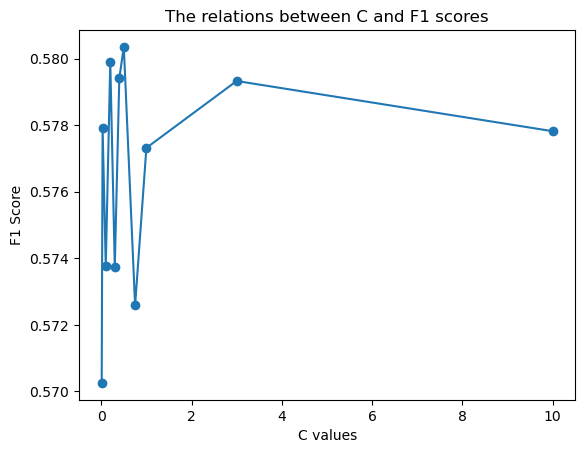

In [6]:
# To adjust C value of Logistic Regression's hyper param
C_values = [0.01, 0.03, 0.1, 0.3, 0.5, 0.75, 1 , 3]
scores = []


for C in C_values:
    rng_lr = LogisticRegression(
        max_iter=2000,
        C=C,
        class_weight='balanced',
        random_state=1234
    )
    rng_lr.fit(X_train, y_train)
    pred = rng_lr.predict(X_valid)
    f1 = f1_score(y_valid, pred)
    scores.append(f1)
    print(f'C={C}, F1 = {f1:.4f}')

# Plot the relationship between C values and scores
plt.plot(C_values, scores, marker='o')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.title('The relations between C and F1 scores')
plt.show()

In [7]:
# Logistic Regression has limited : best combination of weight and C results maximum 0.582
# Hence Next model would be SVM since the data has high dimensional shape

# For single SVM, as LR did, working with optimizing C values

for C in C_values:
    l_svm = LinearSVC(
        C=C,
        dual=False,
        max_iter=5000,
        tol=1e-3
    )

    l_svm.fit(X_train, y_train)
    
    pred = l_svm.predict(X_valid)
    f1 = f1_score(y_valid, pred)

    decision_scores = l_svm.decision_function(X_valid)

    roc_auc = roc_auc_score(y_valid, decision_scores)
    pr_auc = average_precision_score(y_valid, decision_scores)
    
    print(f"C={C} | F1={f1:.4f} | ROC-AUC={roc_auc:.4f} | PR-AUC={pr_auc:.4f}")


C=0.01, F1 = 0.5826
C=0.03, F1 = 0.5845
C=0.1, F1 = 0.5841
C=0.2, F1 = 0.5831
C=0.3, F1 = 0.5830
C=0.4, F1 = 0.5832
C=0.5, F1 = 0.5830
C=0.75, F1 = 0.5830
C=1, F1 = 0.5829
C=3, F1 = 0.5828
C=10, F1 = 0.5827


In [ ]:
# Applied PCA to reduce dimensions and run Random Forest and XGbost

dims = [20, 50, 100, 150, 200, 300]
results = {}

for d in dims:
    print(f"\n===== PCA {d} Dimensions =====")
    pca = PCA(n_components=d)
    X_train_p = pca.fit_transform(X_train)
    X_valid_p = pca.transform(X_valid)
    
    for n_estimator in [100, 300, 500, 1000]:
        rf = RandomForestClassifier(
            n_estimators = n_estimator,
            max_depth = 12,
            n_jobs = -1
        )
        rf.fit(X_train_p, y_train)
        pred = rf.predict(X_valid_p)
        f1_rf = f1_score(y_valid, pred)

        probs_rf = rf.predict_proba(X_valid_p)[:, 1]
        roc_rf = roc_auc_score(y_valid, probs_rf)
        pr_auc_rf = average_precision_score(y_valid, probs_rf)

        print(f'[RF] dim={d}, nest={n_estimator} → F1={f1_rf:.4f} | ROC={roc_rf:.4f} | PR={pr_auc_rf:.4f}')

        for learn_rate in [0.001, 0.005, 0.01, 0.025, 0.05]:
            xgb = XGBClassifier(
                n_estimators = n_estimator,
                learning_rate = learn_rate,
                max_depth=6,
                subsample = 0.8,
                colsample_bytree=0.8
            )
            xgb.fit(X_train_p, y_train)
            pred = xgb.predict(X_valid_p)
            f1_xgb = f1_score(y_valid, pred)

            probs_xgb = xgb.predict_proba(X_valid_p)[:, 1]
            roc_xgb = roc_auc_score(y_valid, probs_xgb)
            pr_auc_xgb = average_precision_score(y_valid, probs_xgb)
            
            print(f'[XGB] dim={d}, nest={n_estimator}, lr={learn_rate} → F1={f1_xgb:.4f} | ROC={roc_xgb:.4f} | PR={pr_auc_xgb:.4f}')


===== PCA 20 Dimensions =====
[RF] dim=20, nest=100 → F1=0.5345 | ROC=0.5572 | PR=0.5486
[XGB] dim=20, nest=100, lr=0.001 → F1=0.5182 | ROC=0.5479 | PR=0.5434
[XGB] dim=20, nest=100, lr=0.005 → F1=0.5208 | ROC=0.5504 | PR=0.5454
[XGB] dim=20, nest=100, lr=0.01 → F1=0.5208 | ROC=0.5534 | PR=0.5479
[XGB] dim=20, nest=100, lr=0.025 → F1=0.5286 | ROC=0.5611 | PR=0.5541
[XGB] dim=20, nest=100, lr=0.05 → F1=0.5364 | ROC=0.5671 | PR=0.5589
[RF] dim=20, nest=300 → F1=0.5348 | ROC=0.5587 | PR=0.5498
[XGB] dim=20, nest=300, lr=0.001 → F1=0.5233 | ROC=0.5494 | PR=0.5448
[XGB] dim=20, nest=300, lr=0.005 → F1=0.5256 | ROC=0.5568 | PR=0.5507
[XGB] dim=20, nest=300, lr=0.01 → F1=0.5337 | ROC=0.5633 | PR=0.5563
[XGB] dim=20, nest=300, lr=0.025 → F1=0.5424 | ROC=0.5715 | PR=0.5626
[XGB] dim=20, nest=300, lr=0.05 → F1=0.5459 | ROC=0.5758 | PR=0.5653
[RF] dim=20, nest=500 → F1=0.5348 | ROC=0.5585 | PR=0.5499
[XGB] dim=20, nest=500, lr=0.001 → F1=0.5243 | ROC=0.5505 | PR=0.5458
[XGB] dim=20, nest=500, lr

In [3]:
# Stochastic Gradient Descent (SGD)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for a in alphas:
    print(f'\n----------------------- Alpha : {a} -------------------------')

    # ------- Hinge (SVM) -------
    sgd_svm = SGDClassifier(
        loss='hinge',
        alpha=a,
        penalty='l2',
        max_iter=3000,
        tol=1e-3
    )
    sgd_svm.fit(X_train, y_train)

    pred = sgd_svm.predict(X_valid)
    f1_svm = f1_score(y_valid, pred)

    scores_svm = sgd_svm.decision_function(X_valid)
    roc_svm = roc_auc_score(y_valid, scores_svm)
    pr_svm = average_precision_score(y_valid, scores_svm)

    print(f"[SGD SVM] F1={f1_svm:.4f} | ROC-AUC={roc_svm:.4f} | PR-AUC={pr_svm:.4f}")


    # ------- Logistic (log loss) -------
    sgd_log = SGDClassifier(
        loss='log_loss',
        alpha=a,
        penalty='l2',
        max_iter=3000,
        tol=1e-3
    )
    sgd_log.fit(X_train, y_train)

    pred = sgd_log.predict(X_valid)
    f1_log = f1_score(y_valid, pred)

    probs_log = sgd_log.predict_proba(X_valid)[:, 1]
    roc_log = roc_auc_score(y_valid, probs_log)
    pr_log = average_precision_score(y_valid, probs_log)

    print(f"[SGD LOG] F1={f1_log:.4f} | ROC-AUC={roc_log:.4f} | PR-AUC={pr_log:.4f}")


----------------------- Alpha : 1e-05 -------------------------
[SGD SVM] F1=0.6665 | ROC-AUC=0.5601 | PR-AUC=0.5284
[SGD LOG] F1=0.6533 | ROC-AUC=0.5604 | PR-AUC=0.5308

----------------------- Alpha : 0.0001 -------------------------
[SGD SVM] F1=0.6599 | ROC-AUC=0.5584 | PR-AUC=0.5288
[SGD LOG] F1=0.6086 | ROC-AUC=0.5586 | PR-AUC=0.5298

----------------------- Alpha : 0.001 -------------------------
[SGD SVM] F1=0.5845 | ROC-AUC=0.5546 | PR-AUC=0.5316
[SGD LOG] F1=0.5480 | ROC-AUC=0.5565 | PR-AUC=0.5307

----------------------- Alpha : 0.01 -------------------------
[SGD SVM] F1=0.6668 | ROC-AUC=0.5517 | PR-AUC=0.5315
[SGD LOG] F1=0.5003 | ROC-AUC=0.5535 | PR-AUC=0.5316

----------------------- Alpha : 0.1 -------------------------
[SGD SVM] F1=0.0000 | ROC-AUC=0.5517 | PR-AUC=0.5315
[SGD LOG] F1=0.4940 | ROC-AUC=0.5519 | PR-AUC=0.5315


In [5]:
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()

    # AUC plot
    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='train_auc')
    plt.plot(history.history['val_auc'], label='val_auc')
    plt.title('AUC')
    plt.legend()

    plt.show()

C:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6325 - auc: 0.6778 - loss: 0.6205 - val_accuracy: 0.6842 - val_auc: 0.7312 - val_loss: 0.5708
Epoch 2/15
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6757 - auc: 0.7216 - loss: 0.5782 - val_accuracy: 0.6923 - val_auc: 0.7432 - val_loss: 0.5594
Epoch 3/15
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6825 - auc: 0.7306 - loss: 0.5675 - val_accuracy: 0.6950 - val_auc: 0.7484 - val_loss: 0.5554
Epoch 4/15
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6871 - auc: 0.7371 - loss: 0.5608 - val_accuracy: 0.6969 - val_auc: 0.7510 - val_loss: 0.5502
Epoch 5/15
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6906 - auc: 0.7414 - loss: 0.5562 - val_accuracy: 0.7001 - val_auc: 0.7521 - val_loss: 0.5444
Epoch 6/15
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6923 - auc: 0.7442 - loss: 0.5530 - val_accuracy: 0.7018 - val_auc: 0.7559 - val_loss: 0.5417
Epoch 7/15
7287/7287 ━

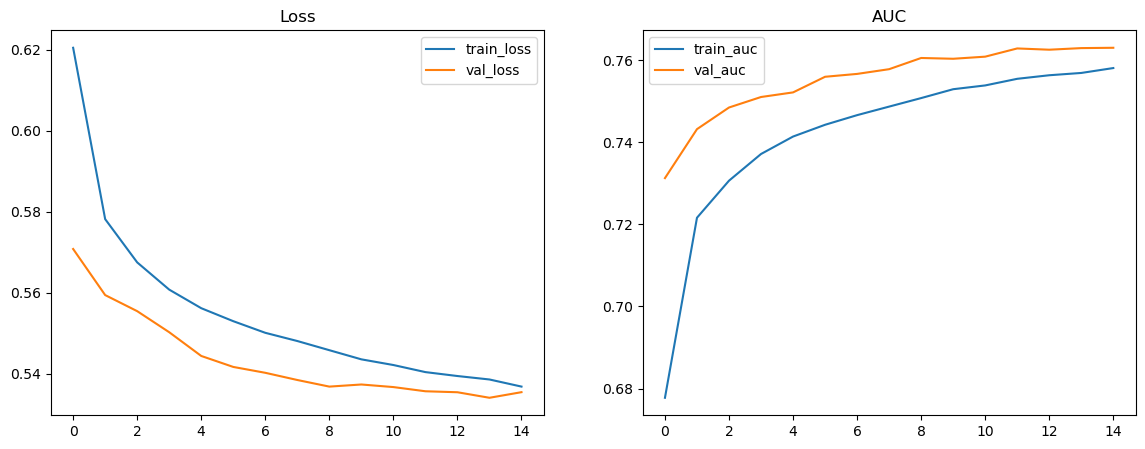

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7049 - auc: 0.7630 - loss: 0.5354
Validation Loss: 0.5354
Validation Accuracy: 0.7049
Validation ROC-AUC: 0.7630


In [4]:
# Deep Learning : Sequential -> MLP (Single Input )

dl_one_input = Sequential([
    Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

dl_one_input.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
)


history = dl_one_input.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=64
)

plot_history(history)
loss, acc, auc = dl_one_input.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Epoch 1/15
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.6335 - auc: 0.6794 - loss: 0.6183 - val_accuracy: 0.6879 - val_auc: 0.7336 - val_loss: 0.5650
Epoch 2/15
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.6820 - auc: 0.7266 - loss: 0.5702 - val_accuracy: 0.6969 - val_auc: 0.7457 - val_loss: 0.5514
Epoch 3/15
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.6911 - auc: 0.7390 - loss: 0.5575 - val_accuracy: 0.7016 - val_auc: 0.7545 - val_loss: 0.5419
Epoch 4/15
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.6956 - auc: 0.7455 - loss: 0.5497 - val_accuracy: 0.7038 - val_auc: 0.7578 - val_loss: 0.5385
Epoch 5/15
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.6989 - auc: 0.7503 - loss: 0.5446 - val_accuracy: 0.7063 - val_auc: 0.7608 - val_loss: 0.5350
Epoch 6/15
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7015 - auc: 0.7545 - loss: 0.5399 - val_accuracy: 0.7064 - val_auc: 0.7621 - val_loss: 0.5350
Epoch 7/15
3644/3644 ━

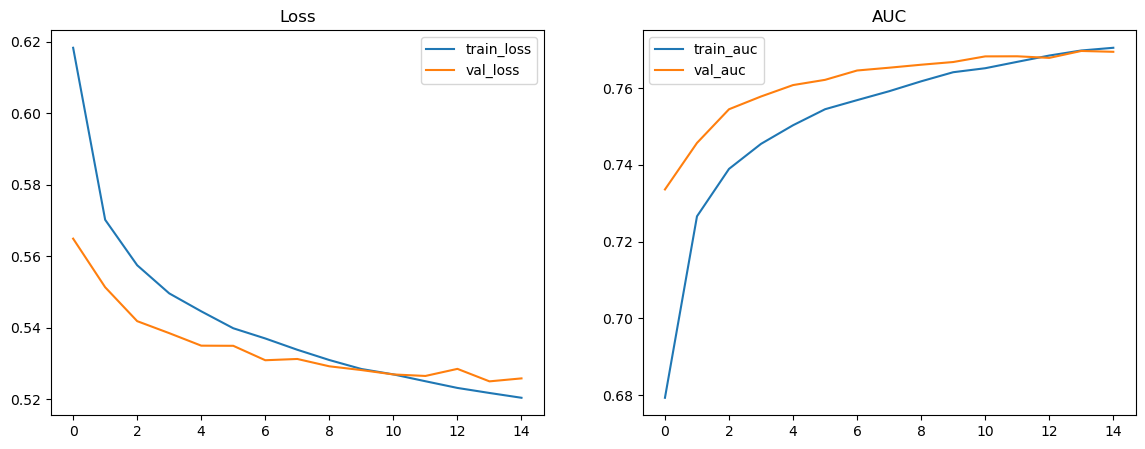

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7049 - auc: 0.7630 - loss: 0.5354
Validation Loss: 0.5354
Validation Accuracy: 0.7049
Validation ROC-AUC: 0.7630


In [5]:
# Deep Learning : Sequential -> MLP (Single Input 2)

dl_one_input2 = Sequential([
    Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

dl_one_input2.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
)


history = dl_one_input2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=128
)

plot_history(history)
loss, acc, auc = dl_one_input2.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Epoch 1/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6333 - auc: 0.6812 - loss: 0.6174 - val_accuracy: 0.6872 - val_auc: 0.7365 - val_loss: 0.5645
Epoch 2/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6851 - auc: 0.7304 - loss: 0.5662 - val_accuracy: 0.6993 - val_auc: 0.7500 - val_loss: 0.5480
Epoch 3/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.6925 - auc: 0.7422 - loss: 0.5541 - val_accuracy: 0.7025 - val_auc: 0.7562 - val_loss: 0.5405
Epoch 4/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6973 - auc: 0.7484 - loss: 0.5474 - val_accuracy: 0.7027 - val_auc: 0.7580 - val_loss: 0.5393
Epoch 5/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7002 - auc: 0.7525 - loss: 0.5425 - val_accuracy: 0.7063 - val_auc: 0.7623 - val_loss: 0.5336
Epoch 6/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7026 - auc: 0.7558 - loss: 0.5380 - val_accuracy: 0.7060 - val_auc: 0.7631 - val_loss: 0.5335
Epoch 7/20
3644/3644 ━

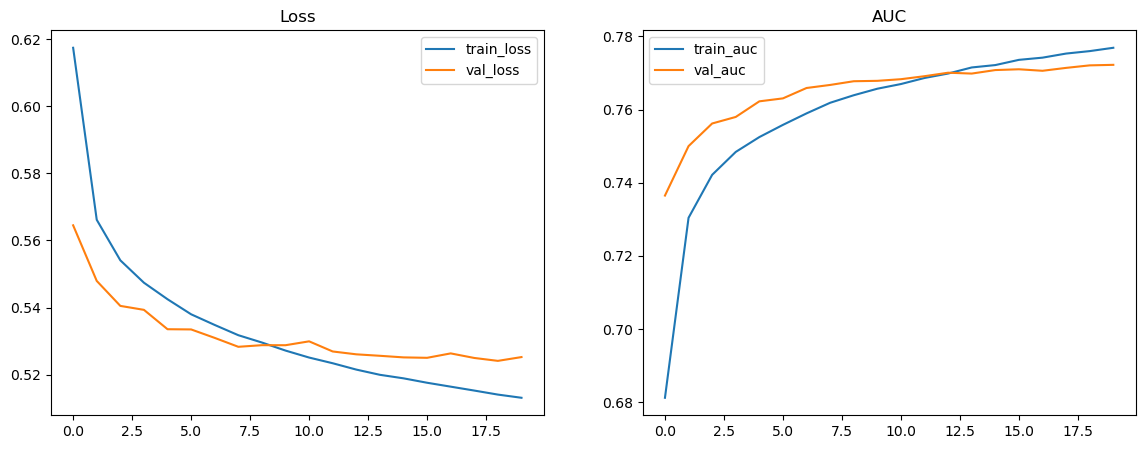

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7123 - auc: 0.7722 - loss: 0.5253
Validation Loss: 0.5253
Validation Accuracy: 0.7123
Validation ROC-AUC: 0.7722


In [6]:
# Deep Learning : Sequential -> MLP (Single Input 2 + 20 epoch)

dl_one_input3 = Sequential([
    Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

dl_one_input3.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
)


history = dl_one_input3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=128
)

plot_history(history)
loss, acc, auc = dl_one_input3.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Epoch 1/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6096 - auc: 0.6480 - loss: 0.6403 - val_accuracy: 0.6575 - val_auc: 0.6996 - val_loss: 0.6002
Epoch 2/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6506 - auc: 0.6911 - loss: 0.6052 - val_accuracy: 0.6668 - val_auc: 0.7099 - val_loss: 0.5880
Epoch 3/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6600 - auc: 0.7019 - loss: 0.5947 - val_accuracy: 0.6733 - val_auc: 0.7192 - val_loss: 0.5802
Epoch 4/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6652 - auc: 0.7081 - loss: 0.5882 - val_accuracy: 0.6769 - val_auc: 0.7220 - val_loss: 0.5753
Epoch 5/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6682 - auc: 0.7111 - loss: 0.5839 - val_accuracy: 0.6804 - val_auc: 0.7261 - val_loss: 0.5715
Epoch 6/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6712 - auc: 0.7147 - loss: 0.5808 - val_accuracy: 0.6828 - val_auc: 0.7276 - val_loss: 0.5676
Epoch 7/20
3644/3644 ━

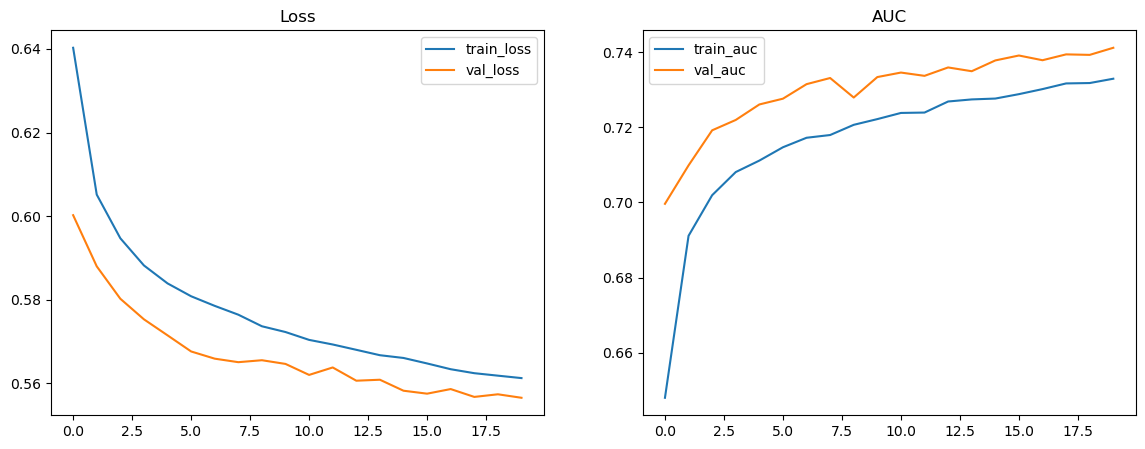

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6893 - auc: 0.7412 - loss: 0.5566
Validation Loss: 0.5566
Validation Accuracy: 0.6893
Validation ROC-AUC: 0.7412


In [9]:
# Deep Learning : Sequential -> MLP (Separated Input)
# Title branch
title_input = Input(shape=(768,), name='title_input')
x1 = Dense(256, activation='relu')(title_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.2)(x1)

# Content branch
content_input = Input(shape=(768,), name='content_input')
x2 = Dense(256, activation='relu')(content_input)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

x2 = Dense(128, activation='relu')(x2)
x2 = Dropout(0.2)(x2)

# Merge
merged = Concatenate()([x1, x2])

# Final classifier
h = Dense(128, activation='relu')(merged)
h = Dropout(0.3)(h)

output = Dense(1, activation='sigmoid')(h)

dl_sep_input = Model(inputs=[title_input, content_input], outputs=output)

dl_sep_input.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history = dl_sep_input.fit(
    [X_title_train, X_content_train], y_sep_train,
    validation_data=([X_title_valid, X_content_valid], y_sep_valid),
    epochs=20,
    batch_size=128
)

plot_history(history)

loss, acc, auc = dl_sep_input.evaluate(
    [X_title_valid, X_content_valid],
    y_sep_valid
)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Epoch 1/25
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5871 - auc: 0.6211 - loss: 0.6621 - val_accuracy: 0.6547 - val_auc: 0.6976 - val_loss: 0.6071 - learning_rate: 0.0010
Epoch 2/25
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6477 - auc: 0.6884 - loss: 0.6135 - val_accuracy: 0.6760 - val_auc: 0.7228 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 3/25
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6592 - auc: 0.7026 - loss: 0.5992 - val_accuracy: 0.6827 - val_auc: 0.7310 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 4/25
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6668 - auc: 0.7117 - loss: 0.5909 - val_accuracy: 0.6903 - val_auc: 0.7388 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 5/25
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6728 - auc: 0.7186 - loss: 0.5838 - val_accuracy: 0.6919 - val_auc: 0.7413 - val_loss: 0.5591 - learning_rate: 0.0010
Epoch 6/25
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy

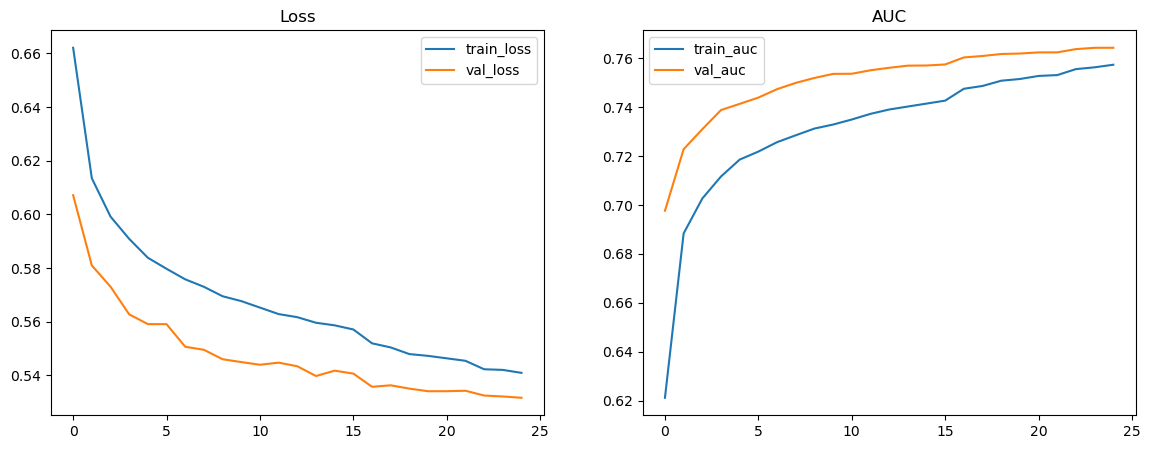

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7076 - auc: 0.7643 - loss: 0.5317
Validation Loss: 0.5317
Validation Accuracy: 0.7076
Validation ROC-AUC: 0.7643


In [11]:
# MLP: epoch 25with scheduler 

# Deep Learning : Sequential -> MLP (Single Input 2 + 20 epoch)

dl_one_input3 = Sequential([
    Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

dl_one_input3.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)


history = dl_one_input3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=25,
    batch_size=128,
    callbacks=[lr_schedule]
)

plot_history(history)
loss, acc, auc = dl_one_input3.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

In [3]:
# Siamese Interaction MLP (Interaction based deep model)

title_input = Input(shape=(768,), name='title_input')
content_input = Input(shape=(768,), name='content_input')

# Interaction features
multiply = tf.keras.layers.Multiply()([title_input, content_input])
diff = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([title_input, content_input])

# Combine all interaction features
merged = Concatenate()([title_input, content_input, multiply, diff])

# Deep classifier
h = Dense(512, activation='relu')(merged)
h = Dropout(0.3)(h)

h = Dense(256, activation='relu')(h)
h = Dropout(0.2)(h)

h = Dense(128, activation='relu')(h)
h = Dropout(0.1)(h)

output = Dense(1, activation='sigmoid')(h)

siamese_model = Model(inputs=[title_input, content_input], outputs=output)

siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

siamese_model.summary()


history = siamese_model.fit(
    [X_title_train, X_content_train], y_sep_train,
    validation_data=([X_title_valid, X_content_valid], y_sep_valid),
    epochs=20,
    batch_size=128
)

plot_history(history)
loss, acc, auc = siamese_model.evaluate(
    [X_title_valid, X_content_valid],
    y_sep_valid
)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)      │ (None, 768)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ content_input (InputLayer)    │ (None, 768)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 768)               │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 768)               │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 3072)              │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0],       │
│                               │                           │                 │ multiply[0][0],            │
│                               │                           │                 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │       1,573,376 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          32,896 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │             129 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,737,729 (6.63 MB)

 Trainable params: 1,737,729 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.6920 - auc: 0.7333 - loss: 0.5598 - val_accuracy: 0.7082 - val_auc: 0.7561 - val_loss: 0.5365
Epoch 2/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.7075 - auc: 0.7538 - loss: 0.5374 - val_accuracy: 0.7118 - val_auc: 0.7641 - val_loss: 0.5286
Epoch 3/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.7107 - auc: 0.7615 - loss: 0.5305 - val_accuracy: 0.7132 - val_auc: 0.7663 - val_loss: 0.5265
Epoch 4/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.7126 - auc: 0.7653 - loss: 0.5266 - val_accuracy: 0.7149 - val_auc: 0.7716 - val_loss: 0.5234
Epoch 5/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.7141 - auc: 0.7680 - loss: 0.5229 - val_accuracy: 0.7165 - val_auc: 0.7733 - val_loss: 0.5212
Epoch 6/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.7158 - auc: 0.7706 - loss: 0.5203 - val_accuracy: 0.7149 - val_auc: 0.7734 - val_loss: 0.5213
Epoch 7/20
3644/3644 ━

NameError: name 'plot_history' is not defined

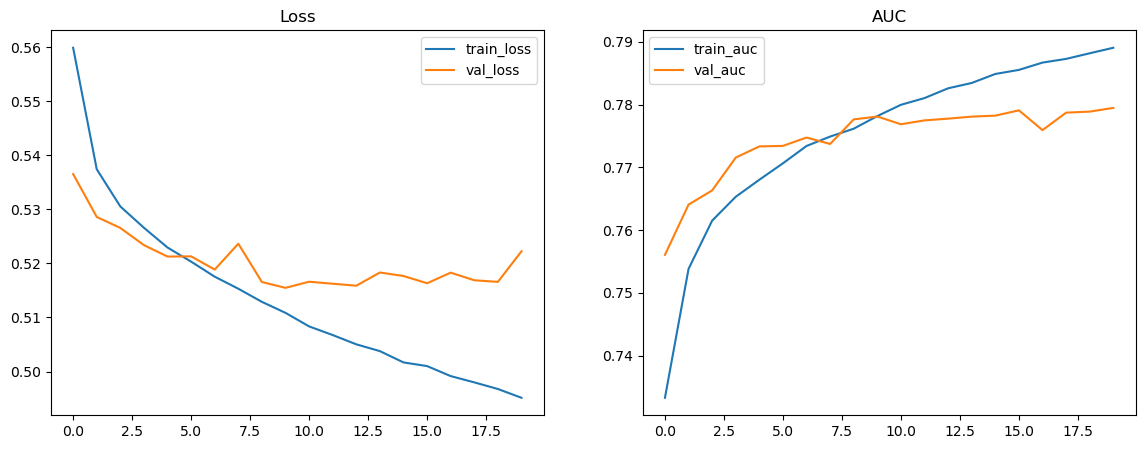

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7190 - auc: 0.7795 - loss: 0.5222
Validation Loss: 0.5222
Validation Accuracy: 0.7190
Validation ROC-AUC: 0.7795


In [5]:
plot_history(history)
loss, acc, auc = siamese_model.evaluate(
    [X_title_valid, X_content_valid],
    y_sep_valid
)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

In [9]:
# XGBoost + MLP Ensemble (Stacking Ensemble)
xgb_model = xgb.XGBClassifier(
    n_estimators=350,       
    max_depth=5,            
    learning_rate=0.04,       
    subsample=0.9,
    colsample_bytree=0.5,     
    min_child_weight=3,     
    reg_lambda=1.5,
    reg_alpha=0.1,
    tree_method='hist',
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred_valid = xgb_model.predict_proba(X_valid)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_valid, xgb_pred_valid))

mlp_pred_valid = siamese_model.predict([X_title_valid, X_content_valid]).reshape(-1)


stack_train = np.vstack([
    mlp_pred_valid,
    xgb_pred_valid,
    np.abs(mlp_pred_valid - xgb_pred_valid),          # diff
    (mlp_pred_valid + xgb_pred_valid) / 2,            # mean
    np.maximum(mlp_pred_valid, xgb_pred_valid),       # max
    np.minimum(mlp_pred_valid, xgb_pred_valid)        # min
]).T

scaler = StandardScaler()
stack_scaled = scaler.fit_transform(stack_train)

meta = LogisticRegression(
    C=3.0,                 
    solver='lbfgs',        
    penalty='l2',
    max_iter=500
)

meta.fit(stack_scaled, y_valid)
final_train_pred = meta.predict_proba(stack_scaled)[:, 1]

print("Stacking AUC:", roc_auc_score(y_valid, final_train_pred))

XGBoost AUC: 0.7136175701955274
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Stacking AUC: 0.7794155957067734


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)      │ (None, 768)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ content_input (InputLayer)    │ (None, 768)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_1 (Multiply)         │ (None, 768)               │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1 (Lambda)             │ (None, 768)               │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 3072)              │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0],       │
│                               │                           │                 │ multiply_1[0][0],          │
│                               │                           │                 │ lambda_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1024)              │       3,146,752 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1024)              │           4,096 │ dense_4[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 1024)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 512)               │         524,800 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 512)               │           2,048 │ dense_5[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 512)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 256)               │         131,328 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 256)               │           1,024 │ dense_6[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,843,073 (14.66 MB)

 Trainable params: 3,839,489 (14.65 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 95s 25ms/step - accuracy: 0.6978 - auc: 0.7402 - loss: 0.5523 - val_accuracy: 0.7066 - val_auc: 0.7598 - val_loss: 0.5404
Epoch 2/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - accuracy: 0.7083 - auc: 0.7576 - loss: 0.5361 - val_accuracy: 0.7109 - val_auc: 0.7654 - val_loss: 0.5305
Epoch 3/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 99s 27ms/step - accuracy: 0.7109 - auc: 0.7629 - loss: 0.5307 - val_accuracy: 0.7131 - val_auc: 0.7704 - val_loss: 0.5240
Epoch 4/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 103s 28ms/step - accuracy: 0.7130 - auc: 0.7672 - loss: 0.5261 - val_accuracy: 0.7136 - val_auc: 0.7716 - val_loss: 0.5240
Epoch 5/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 97s 27ms/step - accuracy: 0.7143 - auc: 0.7706 - loss: 0.5224 - val_accuracy: 0.7160 - val_auc: 0.7740 - val_loss: 0.5189
Epoch 6/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - accuracy: 0.7156 - auc: 0.7733 - loss: 0.5194 - val_accuracy: 0.7153 - val_auc: 0.7747 - val_loss: 0.5202
Epoch 7/20
3644

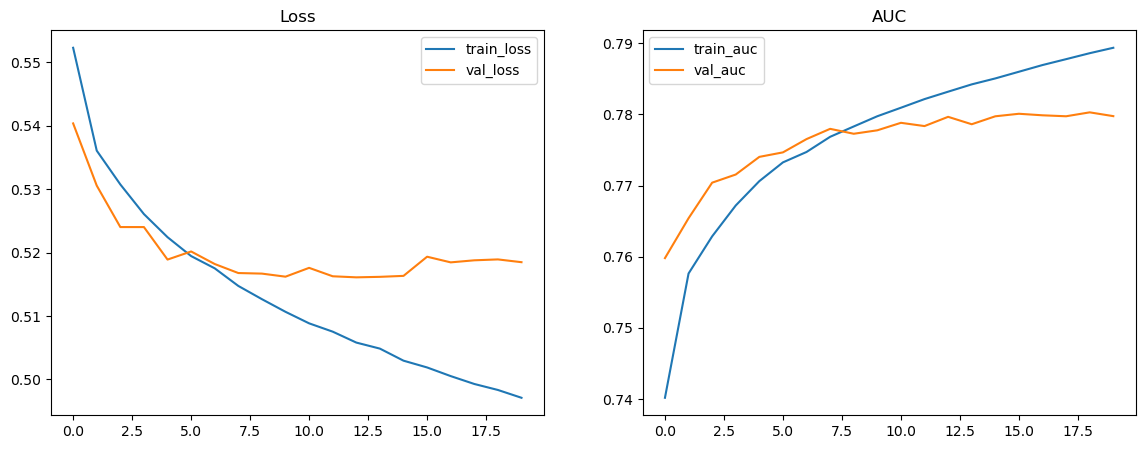

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7181 - auc: 0.7798 - loss: 0.5185
Validation Loss: 0.5185
Validation Accuracy: 0.7181
Validation ROC-AUC: 0.7798


In [10]:
# Siamese V2 -> increase the hidden sizes

# Title & Content Inputs
title_input = Input(shape=(768,), name='title_input')
content_input = Input(shape=(768,), name='content_input')

# Interaction features
multiply = tf.keras.layers.Multiply()([title_input, content_input])
diff = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([title_input, content_input])

# Merge all features (3072 dim)
merged = Concatenate()([title_input, content_input, multiply, diff])

# Deep Interaction MLP
h = Dense(1024, activation='relu')(merged)
h = BatchNormalization()(h)
h = Dropout(0.3)(h)

h = Dense(512, activation='relu')(h)
h = BatchNormalization()(h)
h = Dropout(0.2)(h)

h = Dense(256, activation='relu')(h)
h = BatchNormalization()(h)
h = Dropout(0.1)(h)

h = Dense(128, activation='relu')(h)

output = Dense(1, activation='sigmoid')(h)

siamese_v2 = Model(inputs=[title_input, content_input], outputs=output)

siamese_v2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


siamese_v2.summary()


history = siamese_v2.fit(
    [X_title_train, X_content_train], y_sep_train,
    validation_data=([X_title_valid, X_content_valid], y_sep_valid),
    epochs=20,
    batch_size=128
)

plot_history(history)
loss, acc, auc = siamese_v2.evaluate(
    [X_title_valid, X_content_valid],
    y_sep_valid
)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Epoch 1/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 129s 34ms/step - accuracy: 0.6199 - auc: 0.6611 - loss: 0.6332 - val_accuracy: 0.6784 - val_auc: 0.7243 - val_loss: 0.5744
Epoch 2/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 137s 32ms/step - accuracy: 0.6787 - auc: 0.7224 - loss: 0.5754 - val_accuracy: 0.6943 - val_auc: 0.7454 - val_loss: 0.5536
Epoch 3/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 107s 29ms/step - accuracy: 0.6903 - auc: 0.7385 - loss: 0.5586 - val_accuracy: 0.6996 - val_auc: 0.7537 - val_loss: 0.5447
Epoch 4/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 143s 29ms/step - accuracy: 0.6960 - auc: 0.7464 - loss: 0.5494 - val_accuracy: 0.7035 - val_auc: 0.7577 - val_loss: 0.5388
Epoch 5/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 104s 28ms/step - accuracy: 0.7004 - auc: 0.7525 - loss: 0.5429 - val_accuracy: 0.7055 - val_auc: 0.7609 - val_loss: 0.5352
Epoch 6/20
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - accuracy: 0.7033 - auc: 0.7571 - loss: 0.5378 - val_accuracy: 0.7081 - val_auc: 0.7643 - val_loss: 0.5310
Epoch 7/20


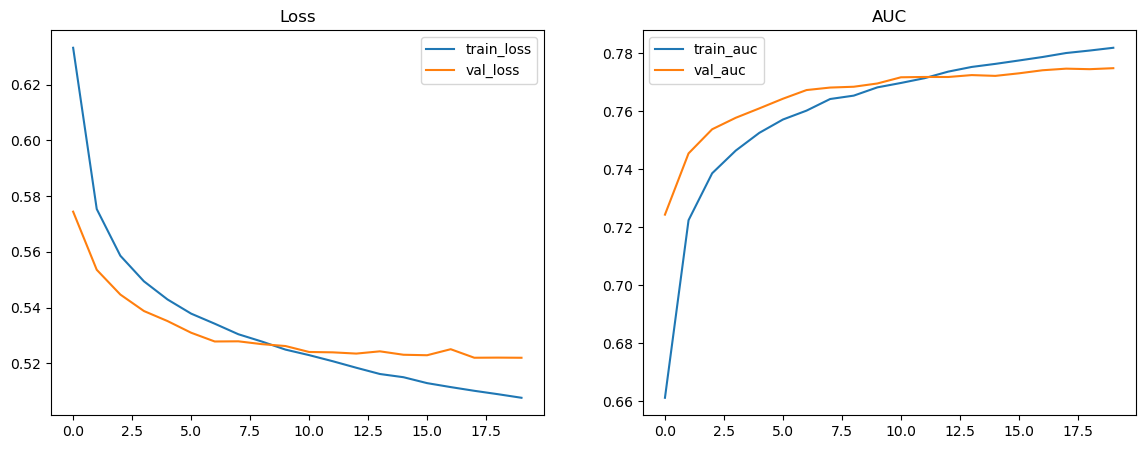

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7138 - auc: 0.7748 - loss: 0.5220
Validation Loss: 0.5220
Validation Accuracy: 0.7138
Validation ROC-AUC: 0.7748


In [7]:
# Deep Learning : Sequential -> MLP (Dense starts with 512)

dl_one_input3 = Sequential([
    Dense(512, activation='relu', input_shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.05),

    Dense(1, activation='sigmoid')
])

dl_one_input3.compile(
    optimizer = Adam(learning_rate=5e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
)



history = dl_one_input3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=128
)

plot_history(history)
loss, acc, auc = dl_one_input3.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)      │ (None, 768)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ content_input (InputLayer)    │ (None, 768)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_2 (Multiply)         │ (None, 768)               │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ abs_diff (AbsDiff)            │ (None, 768)               │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 3072)              │               0 │ title_input[0][0],         │
│                               │                           │                 │ content_input[0][0],       │
│                               │                           │                 │ multiply_2[0][0],          │
│                               │                           │                 │ abs_diff[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 512)               │       1,573,376 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 512)               │           2,048 │ dense_20[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 512)               │               0 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 256)               │         131,328 │ dropout_16[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 256)               │           1,024 │ dense_21[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_17 (Dropout)          │ (None, 256)               │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 128)               │          32,896 │ dropout_17[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 128)               │             512 │ dense_22[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,749,761 (6.67 MB)

 Trainable params: 1,747,841 (6.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/30
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 124s 63ms/step - accuracy: 0.6887 - auc: 0.7297 - loss: 0.7060 - val_accuracy: 0.7071 - val_auc: 0.7582 - val_loss: 0.6401 - learning_rate: 5.0000e-04
Epoch 2/30
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 138s 60ms/step - accuracy: 0.7072 - auc: 0.7541 - loss: 0.6136 - val_accuracy: 0.7111 - val_auc: 0.7646 - val_loss: 0.5846 - learning_rate: 5.0000e-04
Epoch 3/30
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 139s 59ms/step - accuracy: 0.7087 - auc: 0.7584 - loss: 0.5755 - val_accuracy: 0.7115 - val_auc: 0.7652 - val_loss: 0.5611 - learning_rate: 5.0000e-04
Epoch 4/30
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 105s 57ms/step - accuracy: 0.7093 - auc: 0.7595 - loss: 0.5610 - val_accuracy: 0.7112 - val_auc: 0.7658 - val_loss: 0.5523 - learning_rate: 5.0000e-04
Epoch 5/30
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 105s 58ms/step - accuracy: 0.7100 - auc: 0.7602 - loss: 0.5548 - val_accuracy: 0.7129 - val_auc: 0.7678 - val_loss: 0.5479 - learning_rate: 5.0000e-04
Epoch 6/30
1822/1822 ━━━━━━━━━━━━━━

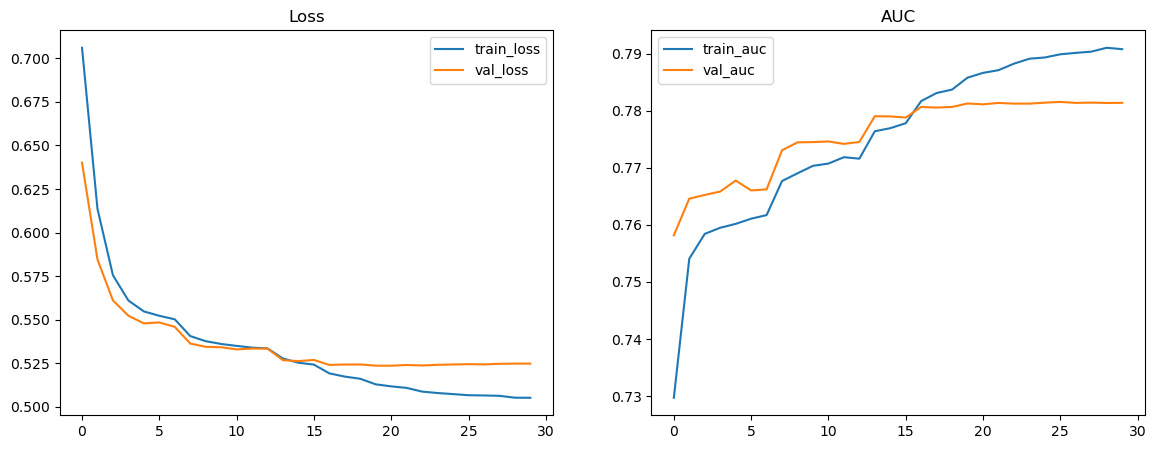

3644/3644 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.7195 - auc: 0.7816 - loss: 0.5245 
Validation Loss: 0.5245
Validation Accuracy: 0.7195
Validation ROC-AUC: 0.7816


In [27]:
# Improved Siamese Interaction MLP (Minimize Overfitting)

# -----------------------------
# Siamese Inputs
# -----------------------------
title_input = Input(shape=(768,), name='title_input')
content_input = Input(shape=(768,), name='content_input')

# -----------------------------
# Interaction features
# -----------------------------
multiply = Multiply()([title_input, content_input])

class AbsDiff(Layer):
    def call(self, inputs):
        t1, t2 = inputs
        return tf.abs(t1 - t2)

diff = AbsDiff()([title_input, content_input])

# Combined feature vector: 768+768+768+768 = 3072 dims
merged = Concatenate()([title_input, content_input, multiply, diff])

# -----------------------------
# Dense Layers 
# -----------------------------
h = Dense(
    512,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=l2(1e-4)
)(merged)
h = BatchNormalization()(h)
h = Dropout(0.25)(h)

h = Dense(
    256,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=l2(1e-4)
)(h)
h = BatchNormalization()(h)
h = Dropout(0.08)(h)

h = Dense(
    128,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=l2(1e-4)
)(h)
h = BatchNormalization()(h)
h = Dropout(0.15)(h)

h = Dense(
    64,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=l2(1e-4)
)(h)
h = BatchNormalization()(h)
h = Dropout(0.05)(h)

# Output
output = Dense(1, activation='sigmoid')(h)

siamese_v3 = Model(inputs=[title_input, content_input], outputs=output)

# -----------------------------
# Compile
# -----------------------------
siamese_v3.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

siamese_v3.summary()

# -----------------------------
# Callbacks: Early Stop + LR Decay
# -----------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=4,          # 4 epoch 동안 개선 없으면 stop
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# -----------------------------
# Train
# -----------------------------
history = siamese_v3.fit(
    [X_title_train, X_content_train],
    y_sep_train,
    validation_data=([X_title_valid, X_content_valid], y_sep_valid),
    epochs=30,
    batch_size=256,
    callbacks=[early_stop, reduce_lr]
)

plot_history(history)

loss, acc, auc = siamese_v3.evaluate(
    [X_title_valid, X_content_valid],
    y_sep_valid
)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC: {auc:.4f}")
